In [1]:
from __future__ import annotations
import os
from pytomography.io.SPECT import simind
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM, OSMAPOSL, BSREM, KEM
from pytomography.io.SPECT import dicom, shared
from pytomography.transforms.shared import GaussianFilter
from torch import poisson
import matplotlib.pyplot as plt
import pytomography
import torch
from pytomography.callbacks import Callback
from pytomography.priors import RelativeDifferencePrior
from pytomography.priors import AnatomyNeighbourWeight, TopNAnatomyNeighbourWeight
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import KEMTransform
from pytomography.projectors.shared import KEMSystemMatrix
import numpy as np
import matplotlib
import matplotlib.patheffects as pe
import itk
import matplotlib.patches as patches
import time
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
input_path = '/disk1/pytomography_paper_data/input'
output_path = '/disk1/pytomography_paper_data/output'

In [3]:
CPS_per_MBq = 5.6212e-3 # to kBq
calib = 1/ CPS_per_MBq / 25 / 0.45**3 # converts to MBq/mL

In [4]:
organs = ['bkg', 'liver', 'lkidney', 'rkidney', 'salivary', 'lesion_mask1', 'lesion_mask2']

In [5]:
volumes = {}
for organ in organs:
    im = np.fromfile(os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177', 'original_masks', f'{organ}_act_av.bin'), dtype=np.float32).reshape((720, 256, 256)).transpose((2,1,0))
    volumes[organ] = (im>0).sum() * 0.15**3 # to mL

In [6]:
activities = [500, 200, 143, 143, 20, 0.7, 0.7] # MBq
# adjust activities for SIMIND projections that have lesions inside other regions
activities_simind = [activity for activity in activities]
activities_simind[-1] = activities_simind[-1] - activities_simind[0]*volumes['lesion_mask1']/volumes['bkg']
activities_simind[-2] = activities_simind[-2] - activities_simind[1]*volumes['lesion_mask2']/volumes['liver']
 
headerfiles = [os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177', organ, 'photopeak.h00') for organ in organs]
headerfiles_lower = [os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177', organ, 'upperscatter.h00') for organ in organs]
projections = simind.get_projections([headerfiles, headerfiles_lower, headerfiles_upper], weights=activities_simind)
projections.shape
object_meta, proj_meta = simind.get_metadata(headerfiles[0])

# Subsample to match the 
object_meta, proj_meta, projections = shared.subsample_projections_and_modify_metadata(object_meta, proj_meta, projections, N_angle=2)

In [7]:
dT = 25 # seconds per projection
projections_realization = torch.poisson(projections * dT)
photopeak = projections_realization[0]
ww_peak = simind.get_energy_window_width(headerfiles[0])
ww_lower = simind.get_energy_window_width(headerfiles_lower[0])
ww_upper = simind.get_energy_window_width(headerfiles_upper[0])
lower_scatter = projections_realization[1]
upper_scatter = projections_realization[2]
scatter = (lower_scatter/ww_lower+upper_scatter/ww_upper)*ww_peak/2

In [8]:
attenuation_path = os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177', 'temp_output1.hct')
attenuation_map = simind.get_attenuation_map(attenuation_path)[:,56:-56].flip(dims=(1,))
att_transform = SPECTAttenuationTransform(attenuation_map)
psf_meta = simind.get_psfmeta_from_header(headerfiles[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta
    )
likelihood = PoissonLogLikelihood(system_matrix, photopeak, additive_term=scatter)

In [9]:
recon_algorithm = OSEM(likelihood)
start = time.time()
recon_OSEM = recon_algorithm(n_iters = 4, n_subsets = 6) * calib 
end = time.time()
print(f'Time for recon of upper bed per iteration: {(end-start)/4}')

Time for recon of upper bed per iteration: 1.3388976454734802


In [10]:
prior_rdpap = RelativeDifferencePrior(beta=0.3, gamma=2)
recon_algorithm_bsrem = BSREM(
    likelihood = likelihood,
    prior = prior_rdpap
    )
start = time.time()
recon_bsrem_rdp = recon_algorithm_bsrem(40,6) * calib 
end = time.time()
print(f'Time for recon of upper bed per iteration: {(end-start)/40}')

Time for recon of upper bed per iteration: 1.176099854707718


In [11]:
weight_top8anatomy = TopNAnatomyNeighbourWeight(attenuation_map, N_neighbours=8)
prior_rdpap = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy)
recon_algorithm_bsrem = BSREM(
    likelihood = likelihood,
    prior = prior_rdpap
    )
start = time.time()
recon_bsrem_rdpap = recon_algorithm_bsrem(40,6) * calib 
end = time.time()
print(f'Time for recon of upper bed per iteration: {(end-start)/40}')

Time for recon of upper bed per iteration: 1.2703396201133728


In [12]:
kem_transform = KEMTransform(
    support_objects=[attenuation_map],
    support_kernels_params=[[0.005]],
    distance_kernel_params=[0.4],
    top_N = 40,
    kernel_on_gpu=True
    )
system_matrix_kem = KEMSystemMatrix(system_matrix, kem_transform)
likelihood_kem = PoissonLogLikelihood(system_matrix_kem, photopeak, additive_term=scatter)
recon_algorithm_kem = KEM(likelihood_kem)
start = time.time()
recon_kem = recon_algorithm_kem(10,6) * calib 
end = time.time()
print(f'Time for recon of upper bed per iteration: {(end-start)/10}')

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


Time for recon of upper bed per iteration: 1.5783138990402221


In [13]:
activity_concentrations = {}
for i, organ in enumerate(organs):
    activity_concentrations[organ] = activities[i] / volumes[organ]

In [14]:
im = np.fromfile(os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177','original_masks', 'act_phantom_act_av.bin'), dtype=np.float32).reshape((720, 256, 256)).transpose((2,1,0))
affine_fixed = np.array([
    [0.15,0,0,-0.15*(256/2-0.5)],
    [0,0.15,0,-0.15*(256/2-0.5)],
    [0,0,0.15,0],
    [0,0,0,1]
])
affine_moving = np.array([
    [0.45,0,0,-0.45*(128/2-0.5)],
    [0,0.45,0,-0.45*(128/2-0.5)],
    [0,0,0.45,0],
    [0,0,0,1]
])
recon_osem_aligned = dicom.align_images_affine(im, recon_OSEM.cpu().numpy(), affine_fixed, affine_moving)
recon_bsrem_rdp_aligned = dicom.align_images_affine(im, recon_bsrem_rdp.cpu().numpy(), affine_fixed, affine_moving)
recon_bsrem_rdpap_aligned = dicom.align_images_affine(im, recon_bsrem_rdpap.cpu().numpy(), affine_fixed, affine_moving)
recon_kem_aligned = dicom.align_images_affine(im, recon_kem.cpu().numpy(), affine_fixed, affine_moving)

In [15]:
os.path.join(input_path, 'spect_simind_experiment', 'masks', 'liver_sphere_mask.seg.nrrd')

atn_img = np.fromfile(os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177', 'original_masks', 'act_phantom_atn_av.bin'), dtype=np.float32).reshape((720, 256, 256)).transpose((2,1,0))
liver_sphere_mask = np.transpose(itk.GetArrayFromImage(itk.imread(os.path.join(input_path, 'spect_simind_experiment', 'masks', 'liver_sphere_mask.seg.nrrd'))), (1,2,0))==1

In [16]:
def get_mask(organ):
    mask = np.fromfile(os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177', 'original_masks', f'{organ}_act_av.bin'), dtype=np.float32).reshape((720, 256, 256)).transpose((2,1,0)) > 0
    if organ=='liver':
        mask_lesion2 = np.fromfile(os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177', 'original_masks', 'lesion_mask2_act_av.bin'), dtype=np.float32).reshape((720, 256, 256)).transpose((2,1,0)) > 0
        mask = np.bitwise_xor(mask, mask_lesion2)
    elif organ=='bkg':
        mask_lesion1 = np.fromfile(os.path.join(input_path, 'spect_simind_experiment', 'sim_files_lu177', 'original_masks', 'lesion_mask1_act_av.bin'), dtype=np.float32).reshape((720, 256, 256)).transpose((2,1,0)) > 0
        mask = np.bitwise_xor(mask, mask_lesion1)
    return mask
    
def get_predicted_activity_concentrations(recon):
    predicted_activities = {}
    for organ in organs:
        mask = get_mask(organ)
        predicted_activities[organ] = recon[mask].mean()
    return predicted_activities

def get_liver_sphere_noise(recon):
    return recon[liver_sphere_mask].std() / recon[liver_sphere_mask].mean() * 100

def get_GT(organs, activity_concentrations):
    GT = 0
    for organ in organs:
        mask = get_mask(organ).astype(np.float32)
        GT += activity_concentrations[organ] * mask * 1000 # to kBq
    return GT

In [17]:
osem_activity_concs = get_predicted_activity_concentrations(recon_osem_aligned)
bsrem_rdp_activity_concs = get_predicted_activity_concentrations(recon_bsrem_rdp_aligned)
bsrem_rdpap_activity_concs = get_predicted_activity_concentrations(recon_bsrem_rdpap_aligned)
kem_activity_concs = get_predicted_activity_concentrations(recon_kem_aligned)

In [18]:
osem_liver_sphere_noise = get_liver_sphere_noise(recon_osem_aligned)
bsrem_rdp_liver_sphere_noise = get_liver_sphere_noise(recon_bsrem_rdp_aligned)
bsrem_rdpap_liver_sphere_noise = get_liver_sphere_noise(recon_bsrem_rdpap_aligned)
kem_liver_sphere_noise = get_liver_sphere_noise(recon_kem_aligned)

In [19]:
GT = get_GT(organs, activity_concentrations)

In [20]:
cmap='Greys'
vmax = 500
def plot_object(im, ax, vmax_set=None):
    if vmax_set is not None:
        vmax=vmax_set
    im = ax.pcolormesh(im.max(axis=1).T[200:-50], cmap=cmap, shading='gouraud', vmax=vmax)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return im

def plot_axial_slice(im, ax):
    ax.pcolormesh(atn_img[80:-80,52:103,404][:,::-1].T,  cmap='Greys_r', shading='gouraud')
    ax.pcolormesh(im[80:-80,52:103,404][:,::-1].T,  cmap='hot', alpha=0.5, vmax=500)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
def set_title(act, ax):
    ax.set_title(f'{act["lesion_mask1"]:.2f} MBq/mL ({act["lesion_mask1"] / activity_concentrations["lesion_mask1"] * 100:.1f}%)')
    
def add_liver_circle_coronal(ax, val):
    square = patches.Circle((70, 125), 17, fill=False, edgecolor='red')
    ax.add_patch(square)
    ax.text(70-45,125-35,f'{val:.1f}%', color='red', weight='bold', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")], fontsize=11)
    
def add_kidney_box_coronal(ax, val):
    square = patches.Rectangle((145, 47), 58, 80, fill=False, edgecolor='magenta')
    ax.add_patch(square)
    ax.text(155,28,f'{val:.2f}', color='magenta', weight='bold', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")], fontsize=11)
    
def add_tumour_box_coronal(ax, val):
    style="Simple,head_length=3,head_width=4,tail_width=2"
    arrow = patches.FancyArrowPatch((97,223), (122,208), arrowstyle=style, color='blue')
    ax.add_patch(arrow)
    ax.text(62, 223,f'{val:.2f}', color='blue', weight='bold', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")], fontsize=11)
    
def add_livertumour_box_coronal(ax, val):
    #square = patches.Rectangle((67, 148), 27, 27, fill=False, edgecolor='purple')
    #ax.add_patch(square)
    style="Simple,head_length=3,head_width=4,tail_width=2"
    arrow = patches.FancyArrowPatch((50,180), (75,165), arrowstyle=style, color='purple')
    ax.add_patch(arrow)
    ax.text(15, 180,f'{val:.2f}', color='purple', weight='bold', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")], fontsize=11)

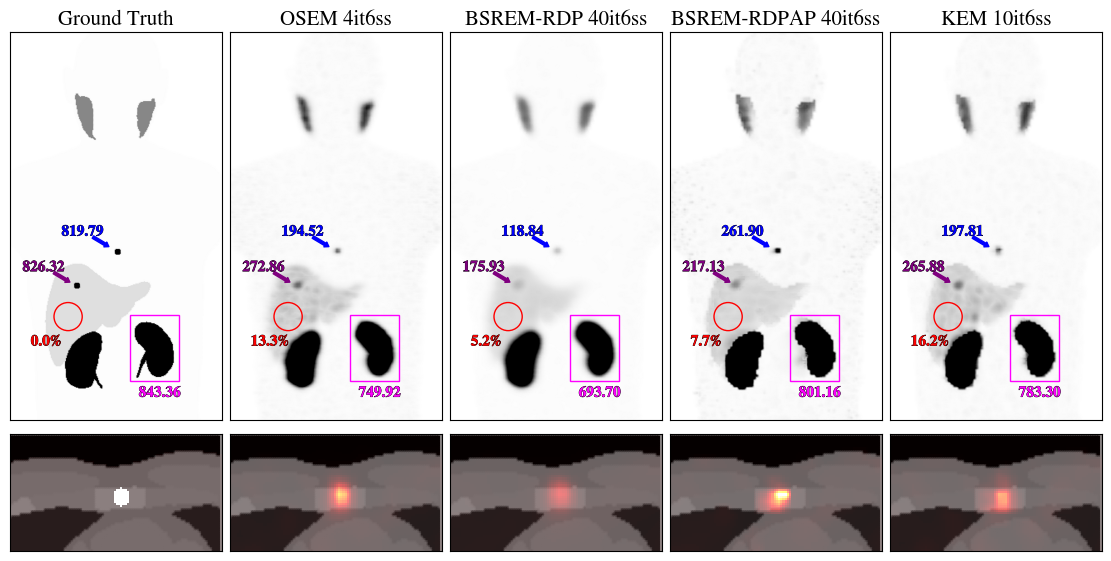

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(11,5.5))
subfigs = fig.subfigures(nrows=2, ncols=1, height_ratios=(1,0.3))
axes = subfigs[0].subplots(nrows=1, ncols=5)
ax = axes[0]
plot_object(GT, ax, vmax_set = vmax)
add_liver_circle_coronal(ax, 0)
add_kidney_box_coronal(ax, activity_concentrations['lkidney']*1000)
add_tumour_box_coronal(ax, activity_concentrations['lesion_mask1']*1000)
add_livertumour_box_coronal(ax, activity_concentrations['lesion_mask2']*1000)
ax.set_title('Ground Truth', fontsize=15)
ax = axes[1]
plot_object(recon_osem_aligned, ax, vmax_set = vmax)
add_liver_circle_coronal(ax, osem_liver_sphere_noise)
add_kidney_box_coronal(ax, osem_activity_concs['lkidney'])
add_tumour_box_coronal(ax, osem_activity_concs['lesion_mask1'])
add_livertumour_box_coronal(ax, osem_activity_concs['lesion_mask2'])
ax.set_title('OSEM 4it6ss', fontsize=15)
ax = axes[2]
plot_object(recon_bsrem_rdp_aligned, ax, vmax_set = vmax)
add_liver_circle_coronal(ax, bsrem_rdp_liver_sphere_noise)
add_kidney_box_coronal(ax, bsrem_rdp_activity_concs['lkidney'])
add_tumour_box_coronal(ax, bsrem_rdp_activity_concs['lesion_mask1'])
add_livertumour_box_coronal(ax, bsrem_rdp_activity_concs['lesion_mask2'])
ax.set_title('BSREM-RDP 40it6ss', fontsize=15)
ax = axes[3]
plot_object(recon_bsrem_rdpap_aligned, ax, vmax_set = vmax)
add_liver_circle_coronal(ax, bsrem_rdpap_liver_sphere_noise)
add_kidney_box_coronal(ax, bsrem_rdpap_activity_concs['lkidney'])
add_tumour_box_coronal(ax, bsrem_rdpap_activity_concs['lesion_mask1'])
add_livertumour_box_coronal(ax, bsrem_rdpap_activity_concs['lesion_mask2'])
ax.set_title('BSREM-RDPAP 40it6ss', fontsize=15)
ax = axes[4]
plot_object(recon_kem_aligned, ax, vmax_set = vmax)
add_liver_circle_coronal(ax, kem_liver_sphere_noise)
add_kidney_box_coronal(ax, kem_activity_concs['lkidney'])
add_tumour_box_coronal(ax, kem_activity_concs['lesion_mask1'])
add_livertumour_box_coronal(ax, kem_activity_concs['lesion_mask2'])
ax.set_title('KEM 10it6ss', fontsize=15)
axes = subfigs[1].subplots(nrows=1, ncols=5)
ax = axes[0]
plot_axial_slice(GT, ax)
ax = axes[1]
plot_axial_slice(recon_osem_aligned, ax)
ax = axes[2]
plot_axial_slice(recon_bsrem_rdp_aligned, ax)
ax = axes[3]
plot_axial_slice(recon_bsrem_rdpap_aligned, ax)
ax = axes[4]
plot_axial_slice(recon_kem_aligned, ax)
plt.savefig('figures/figure3.jpg', dpi=400)